# Run experiment where $t$ is urban vs. rural

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from utils import load_data, RegressionModel, train_model, plot_results

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

For this analysis, we use the "small dataset" with 10k samples selected at random from the full 60K DHS dataset. The data we use consists of latent representations of satllite images $X \in \mathbb{R}^{232}$ and corresponding International Wealth Index (IWI) values $y \in \mathbb{R}$ from survey data. For now, we use the same train-test splits for all experiments, but we should evaluate with cross-validation.

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, t_train, t_val, t_test = load_data(include_rural=True)

Unless otherwised specified, we use the same basic regression model.

In [4]:
RegressionModel()

RegressionModel(
  (fc): Sequential(
    (0): Linear(in_features=232, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Model training

The helper function `train_model`, that creates and trains a `RegressionModel` using gradient descent, has the main arguments `X_train, X_val, y_train, y_val, loss_fn`. `loss_fn` is supposed to be a function that in addition to returning the loss to minimize should return a dict object with whatever metric you would like to log during training.

## MSE baseline

  7%|▋         | 3546/50000 [00:07<01:38, 472.83it/s]


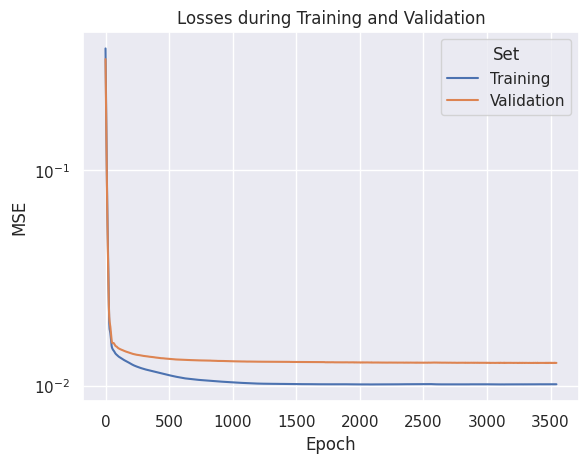

In [5]:
# Example of a loss function that only tracks one metric (MSE)
def mse_loss(pred, target):
    mse = nn.MSELoss()(pred, target)
    return mse, {'MSE': mse.item()}

mse_model = train_model(X_train, X_val, y_train, y_val, lr=1e-3, l2=1e-2, loss_fn=mse_loss, verbose=1)

When we plot the results, we see that the model suffers from attenuation error (the model overestimates wealth for poor places and underestimates for wealthy places).

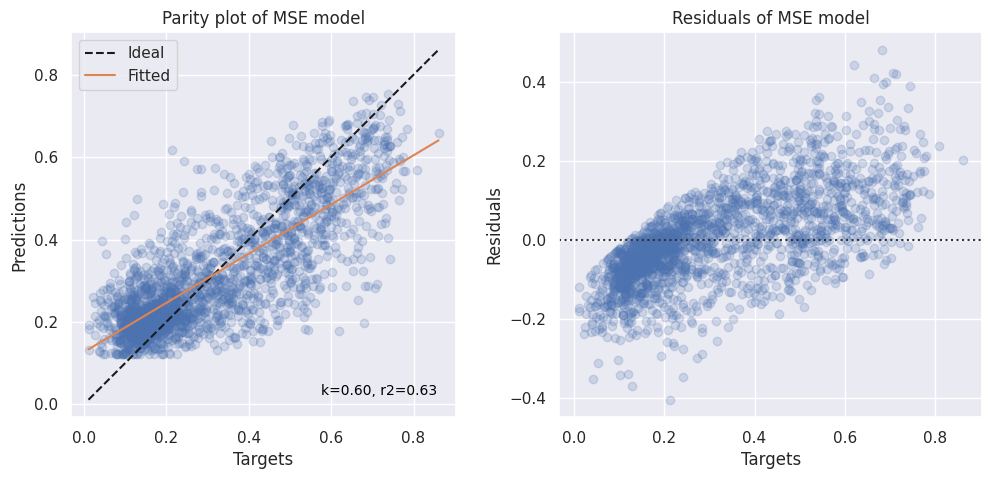

In [83]:
with torch.no_grad():
    y_pred = mse_model(X_test)
    
plot_results(y_test, y_pred, 'MSE model')

In [7]:
tau = y_test[t_test.values].mean().item() - y_test[~t_test.values].mean().item()
tau_hat = y_pred[t_test.values].mean().item() - y_pred[~t_test.values].mean().item()
print(f'True sample tau:{tau:.3f}, Estimated sample tau:{tau_hat:.3f}')

True sample tau:-0.231, Estimated sample tau:-0.152


In [86]:
targets = y_test.cpu().numpy()
predictions = y_pred.cpu().numpy()

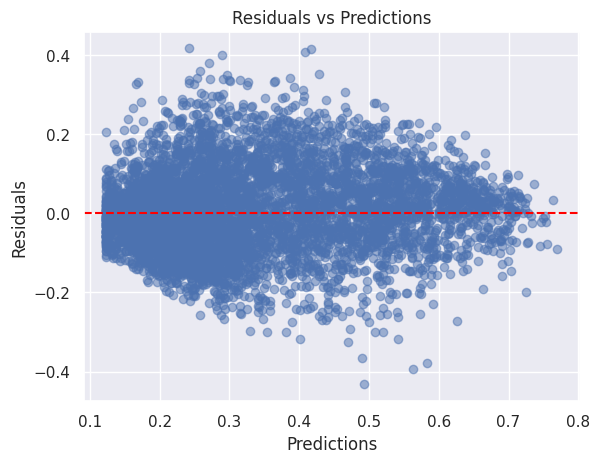

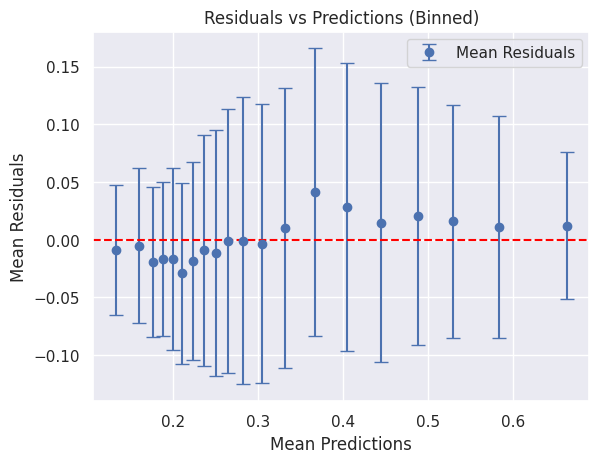

In [82]:
# Plot predictions vs residuals
plt.scatter(predictions, targets - predictions, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

# Divide predictions into ten bins (quintiles)
bins = np.percentile(predictions, np.linspace(0, 100, 21))
bin_indices = np.digitize(predictions, bins) - 1

# Calculate mean predictions and residuals for each bin
bin_means = []
residual_means = []
residual_stds = []

for i in range(20):
    bin_mask = bin_indices == i
    bin_means.append(predictions[bin_mask].mean())
    residuals = (targets - predictions)[bin_mask]
    residual_means.append(residuals.mean())
    residual_stds.append(residuals.std())

# Plot mean residuals with error bars
plt.errorbar(bin_means, residual_means, yerr=residual_stds, fmt='o', capsize=5, label='Mean Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predictions (Binned)')
plt.xlabel('Mean Predictions')
plt.ylabel('Mean Residuals')
plt.legend()
plt.show()

In [53]:
with torch.no_grad():
    val_predictions = mse_model(X_val).cpu().numpy()
    val_targets = y_val.cpu().numpy()

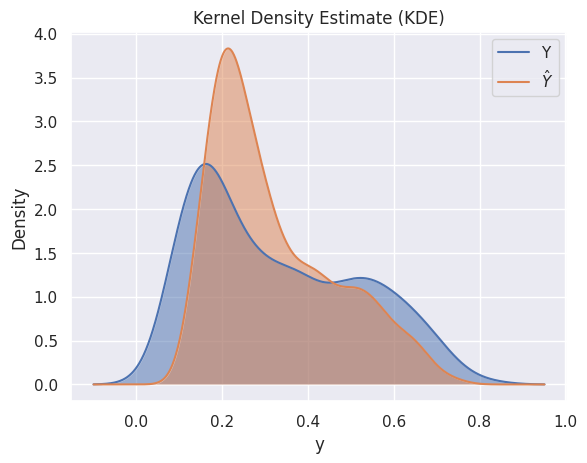

In [64]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Create KDE for marginal density p_Y(y)
target_kde = gaussian_kde(val_targets)
pred_kde = gaussian_kde(predictions)

# Create a range of x values to evaluate the KDE over
y_values = np.linspace(min(val_targets)-0.1, max(val_targets)+0.1, 1000)

# Evaluate the KDE over these x values
target_kde_values = target_kde(y_values)
pred_kde_values = pred_kde(y_values)

# Plot the KDE
plt.plot(y_values, target_kde_values, label="Y")
plt.fill_between(y_values, target_kde_values, alpha=0.5)
plt.plot(y_values, pred_kde_values, label="$\hat{Y}$")
plt.fill_between(y_values, pred_kde_values, alpha=0.5)
plt.title("Kernel Density Estimate (KDE)")
plt.xlabel("y")
plt.ylabel("Density")
plt.legend()
plt.show()

## Estimate score functions

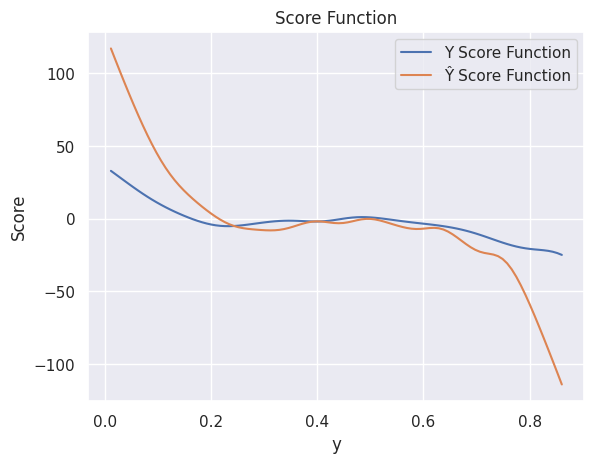

In [65]:
# Define evaluation points (avoid extreme values)
lower = np.percentile(targets, 2.5)
upper = np.percentile(targets, 97.5)
y_vals = np.linspace(min(targets), max(targets), 100)

# Finite difference step for derivative
delta = 1e-5

scores = []
pred_scores = []

def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

for y in y_vals:
    
    # Derivative of log density for targets
    scores.append(score_function(y, target_kde))

    # Derivative of log density for predictions
    pred_scores.append(score_function(y, pred_kde))

# Plot score function
plt.plot(y_vals, scores, label="Y Score Function")
plt.plot(y_vals, pred_scores, label="Ŷ Score Function")
plt.title("Score Function")
plt.xlabel("y")
plt.ylabel("Score")
plt.legend()
plt.show()

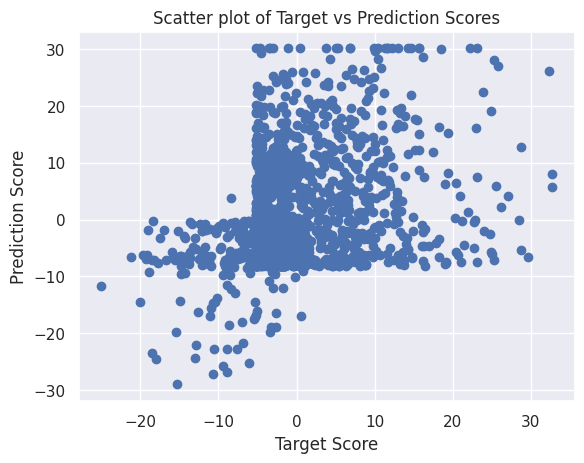

In [66]:
prediction_scores = np.array([score_function(y, pred_kde) for y in predictions])
target_scores = np.array([score_function(y, target_kde) for y in targets])
plt.scatter(target_scores, prediction_scores)
plt.xlabel("Target Score")
plt.ylabel("Prediction Score")
plt.title("Scatter plot of Target vs Prediction Scores")
plt.show()

In [ ]:
f

In [68]:
print('Prediction:', prediction_scores[t_test].mean(), prediction_scores[~t_test].mean())
print('Target:', target_scores[t_test].mean(), target_scores[~t_test].mean())

Prediction: 1.496503101922057 -4.271911890745416
Target: 1.2821346595792666 -3.0574953050914795


In [69]:
tau = targets[t_test].mean() - targets[~t_test].mean()
tau_hat = predictions[t_test].mean() - predictions[~t_test].mean()
print(f'True sample tau:{tau:.5f}, Sample tau hat:{tau_hat:.5f}')

True sample tau:-0.23075, Sample tau hat:-0.15178


In [70]:
adjusted_tau_hat = tau_hat - res_std**2 * (prediction_scores[t_test].mean() - prediction_scores[~t_test].mean())
print(f'Adjusted tau hat:{adjusted_tau_hat:.5f}')

Adjusted tau hat:-0.22525


## Try adjusting each prediction

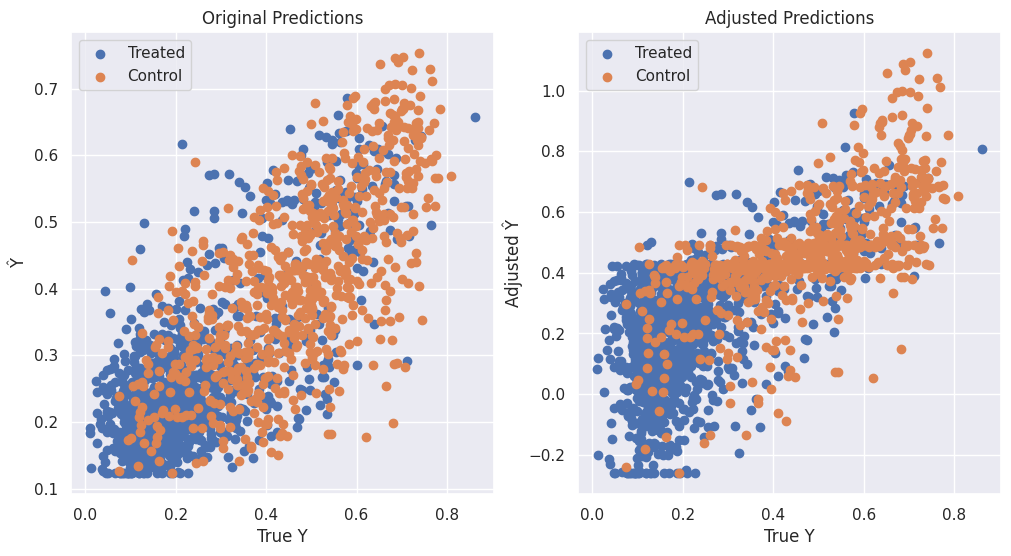

In [87]:
adjusted_predictions = predictions - res_std**2 * (prediction_scores)

# Plot adjusted predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(targets[t_test], predictions[t_test], label="Treated")
plt.scatter(targets[~t_test], predictions[~t_test], label="Control")
plt.title("Original Predictions")
plt.xlabel("True Y")
plt.ylabel("Ŷ")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(targets[t_test], adjusted_predictions[t_test], label="Treated")
plt.scatter(targets[~t_test], adjusted_predictions[~t_test], label="Control")
plt.title("Adjusted Predictions")
plt.xlabel("True Y")
plt.ylabel("Adjusted Ŷ")
plt.legend()
plt.show()

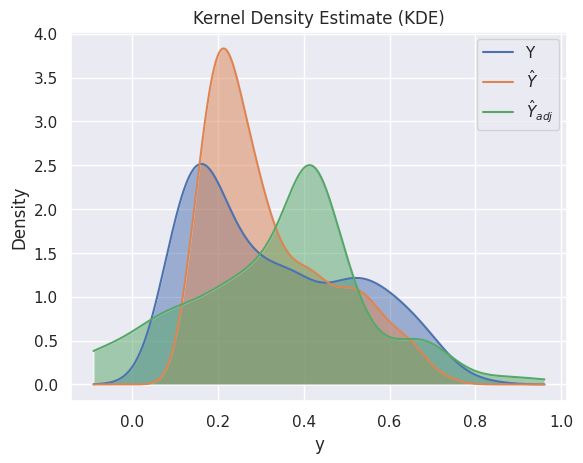

In [88]:
adjusted_pred_kde = gaussian_kde(adjusted_predictions)

# Create a range of x values to evaluate the KDE over
y_values = np.linspace(min(targets)-0.1, max(targets)+0.1, 1000)

# Evaluate the KDE over these x values
target_kde_values = target_kde(y_values)
pred_kde_values = pred_kde(y_values)
adjusted_kde_values = adjusted_pred_kde(y_values)

# Plot the KDE
plt.plot(y_values, target_kde_values, label="Y")
plt.fill_between(y_values, target_kde_values, alpha=0.5)
plt.plot(y_values, pred_kde_values, label="$\hat{Y}$")
plt.fill_between(y_values, pred_kde_values, alpha=0.5)
plt.plot(y_values, adjusted_kde_values, label="$\hat{Y}_{adj}$")
plt.fill_between(y_values, adjusted_kde_values, alpha=0.5)
plt.title("Kernel Density Estimate (KDE)")
plt.xlabel("y")
plt.ylabel("Density")
plt.legend()
plt.show()

---

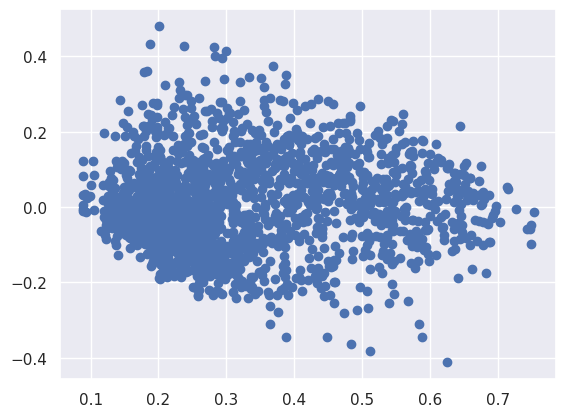

In [10]:
plt.scatter(predictions, (targets - predictions))

In [11]:
# Define evaluation points (avoid extreme values)
lower = np.percentile(targets, 2.5)
upper = np.percentile(targets, 97.5)
y_vals = np.linspace(lower, upper, 100)

In [12]:
mean_std = (targets - predictions).std()

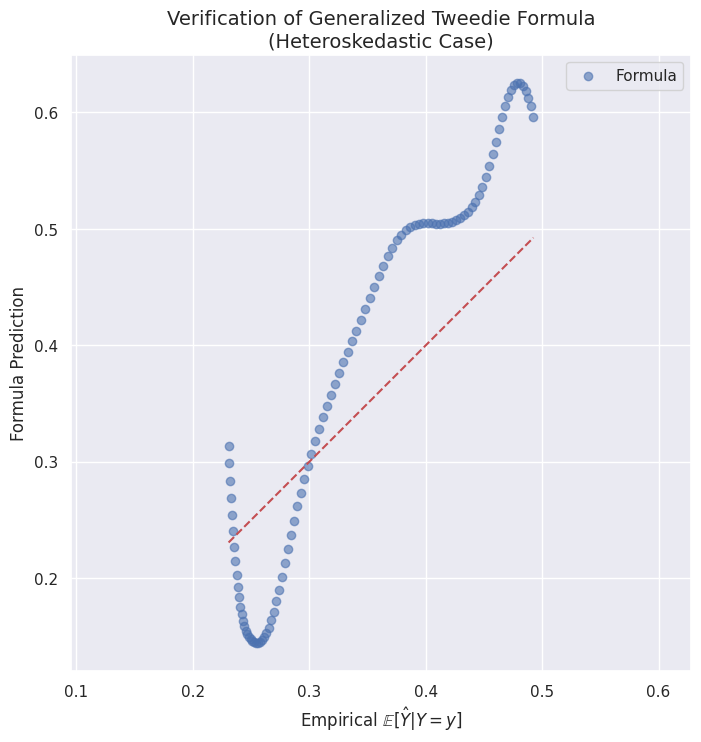

Mean Squared Error (New): 8.26e-03


In [37]:
Y = targets
Ŷ = predictions

# Initialize storage for results
e_Ŷ_empirical = []
e_Ŷ_formula = []

# Bandwidth for kernel regression
h = 0.15  # Adjusted based on Silverman's rule and trial/error

# Finite difference step for derivative
delta = 1e-5
mean_std = (Y - Ŷ).std()

for y in y_vals:
    # Calculate Gaussian kernel weights
    weights = np.exp(-0.5 * ((targets - y)/h)**2)
    sum_weights = np.sum(weights)

    if sum_weights < 1e-5:
        continue  # Skip points with insufficient density
    
    # Empirical conditional expectations
    e_Ŷ_y = np.sum(Ŷ * weights) / sum_weights
    
    # Derivative of log density
    log_p_plus = target_kde.logpdf(y + delta)[0]
    log_p_minus = target_kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    
    rhs = y + mean_std**2 * d_logp
    
    # Store results
    e_Ŷ_empirical.append(e_Ŷ_y)
    e_Ŷ_formula.append(rhs)
    
# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(e_Ŷ_empirical, e_Ŷ_formula, alpha=0.6, label='Formula')
plt.plot([min(e_Ŷ_empirical), max(e_Ŷ_empirical)],
         [min(e_Ŷ_empirical), max(e_Ŷ_empirical)], 'r--')
plt.xlabel('Empirical $\mathbb{E}[\hat{Y}|Y=y]$', fontsize=12)
plt.ylabel('Formula Prediction', fontsize=12)
plt.title('Verification of Generalized Tweedie Formula\n(Heteroskedastic Case)', fontsize=14)
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Calculate MSE
mse = np.mean((np.array(e_Ŷ_empirical) - np.array(e_Ŷ_formula))**2)
print(f"Mean Squared Error (New): {mse:.2e}")

## Train variance estimator

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# === Your data ===
# Assuming you already have these as torch tensors
# X: [N, D], y: [N, 1], y_hat: [N, 1]
# Example (fake) data for testing:
# X = torch.randn(1000, 32)
# y_hat = some_pretrained_model(X).detach()
# y = y_hat + torch.randn_like(y_hat) * 0.5  # simulated noisy labels

# === Model ===
class VarianceModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Predict log(variance)
        )

    def forward(self, x):
        log_var = self.net(x)
        return log_var

# === Loss function ===
def nll_loss_from_fixed_mean(log_var, y, y_hat):
    precision = torch.exp(-log_var)
    return 0.5 * (log_var + precision * (y - y_hat)**2)

# === Training loop ===
def train_variance_model(X, y, y_hat, num_epochs=50, batch_size=64, lr=1e-3):
    dataset = TensorDataset(X, y, y_hat)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = VarianceModel(X.shape[1]).cuda()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y, batch_y_hat in dataloader:
            optimizer.zero_grad()
            log_var = model(batch_X)
            loss = nll_loss_from_fixed_mean(log_var, batch_y, batch_y_hat).mean()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)

        avg_loss = total_loss / len(X)
        print(f"Epoch {epoch+1:02d} - Loss: {avg_loss:.4f}")

    return model

In [33]:
model = train_variance_model(X_test, y_test, y_pred, num_epochs=100, batch_size=32, lr=1e-4)

Epoch 01 - Loss: -0.1068
Epoch 02 - Loss: -0.3181
Epoch 03 - Loss: -0.5887
Epoch 04 - Loss: -0.8965
Epoch 05 - Loss: -1.2018
Epoch 06 - Loss: -1.4210
Epoch 07 - Loss: -1.5409
Epoch 08 - Loss: -1.5864
Epoch 09 - Loss: -1.6010
Epoch 10 - Loss: -1.6111
Epoch 11 - Loss: -1.6159
Epoch 12 - Loss: -1.6186
Epoch 13 - Loss: -1.6220
Epoch 14 - Loss: -1.6249
Epoch 15 - Loss: -1.6252
Epoch 16 - Loss: -1.6265
Epoch 17 - Loss: -1.6282
Epoch 18 - Loss: -1.6284
Epoch 19 - Loss: -1.6277
Epoch 20 - Loss: -1.6301
Epoch 21 - Loss: -1.6300
Epoch 22 - Loss: -1.6300
Epoch 23 - Loss: -1.6317
Epoch 24 - Loss: -1.6315
Epoch 25 - Loss: -1.6330
Epoch 26 - Loss: -1.6327
Epoch 27 - Loss: -1.6334
Epoch 28 - Loss: -1.6320
Epoch 29 - Loss: -1.6339
Epoch 30 - Loss: -1.6346
Epoch 31 - Loss: -1.6341
Epoch 32 - Loss: -1.6354
Epoch 33 - Loss: -1.6352
Epoch 34 - Loss: -1.6357
Epoch 35 - Loss: -1.6365
Epoch 36 - Loss: -1.6348
Epoch 37 - Loss: -1.6364
Epoch 38 - Loss: -1.6351
Epoch 39 - Loss: -1.6365
Epoch 40 - Loss: -1.6366


In [18]:
y_test.device

device(type='cuda', index=0)

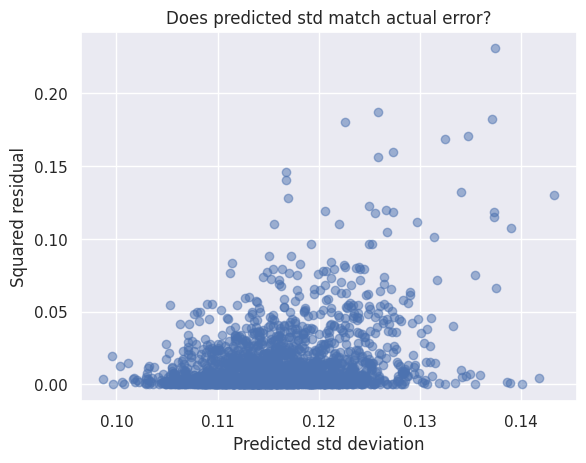

In [34]:
model.eval()
with torch.no_grad():
    log_var_pred = model(X_test)
    var_pred = torch.exp(log_var_pred)
    std_pred = var_pred.sqrt()

# Example: plot predicted std vs. squared residuals
import matplotlib.pyplot as plt

residuals_sq = (y_test - y_pred)**2
plt.scatter(std_pred.cpu().numpy(), residuals_sq.cpu().numpy(), alpha=0.5)
plt.xlabel("Predicted std deviation")
plt.ylabel("Squared residual")
plt.title("Does predicted std match actual error?")
plt.grid(True)
plt.show()


In [27]:
from sklearn.metrics import r2_score

r2_score(residuals_sq.cpu().numpy(), std_pred.cpu().numpy())

-22.184126859974395

## Colab test

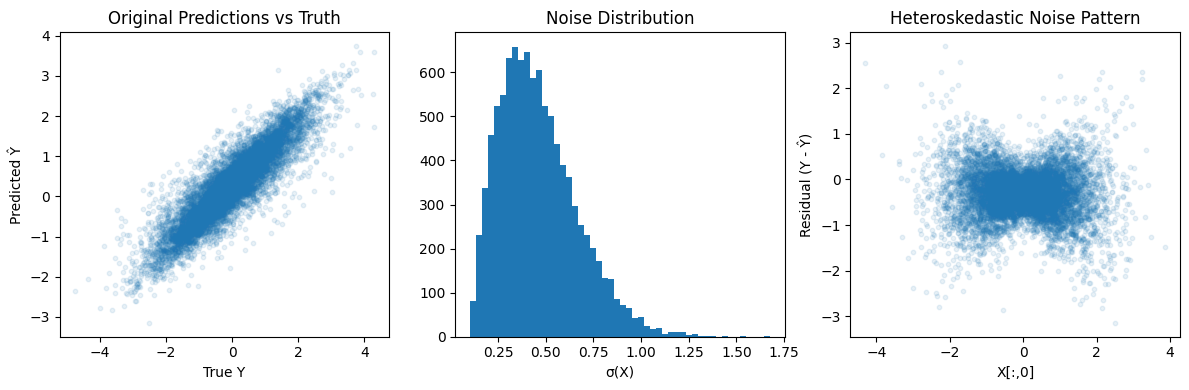

Generated dataset with 10000 samples
Latent dimension: 50
Mean absolute error: 0.47
Noise std range: 0.10 - 1.67


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def generate_dummy_data(n_samples=10000, latent_dim=50, noise_strength=0.3, seed=42):
    """
    Generates synthetic data with:
    - X: Latent image embeddings (standard normal)
    - Y: True regression labels (nonlinear function of X + heteroskedastic noise)
    - Ŷ: Biased predictions (linear approximation of true relationship)
    - sigma_X: True noise standard deviations (for validation)
    """
    np.random.seed(seed)

    # Generate latent embeddings (X)
    X = np.random.normal(size=(n_samples, latent_dim))

    # Create true nonlinear relationship
    true_coef = np.random.normal(size=latent_dim)
    true_coef /= np.linalg.norm(true_coef)  # Normalize

    # Nonlinear components
    nonlinear_terms = (
        2.5 * np.sin(X[:, 0] * 2) +
        1.8 * np.abs(X[:, 1])**1.5 +
        0.7 * X[:, 2] * X[:, 3]
    )

    # True mean function
    true_mean = X.dot(true_coef) #+ nonlinear_terms

    # Heteroskedastic noise model
    sigma_X = 0.1 + noise_strength * (np.abs(X[:, 0]) + 0.5*np.abs(X[:, 1]))
    Y = true_mean + np.random.normal(0, sigma_X)

    # Create biased predictions (Ŷ) using only linear terms
    Ŷ = X.dot(true_coef) * 0.9 + 0.3  # Deliberately misspecified model

    return X, Y, Ŷ, sigma_X

# Generate data -------------------------------------------------
X, Y, Ŷ, true_sigma = generate_dummy_data()

# Visualize -----------------------------------------------------
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(Y, Ŷ, alpha=0.1, s=10)
plt.xlabel('True Y'), plt.ylabel('Predicted Ŷ')
plt.title('Original Predictions vs Truth')

plt.subplot(132)
plt.hist(true_sigma, bins=50)
plt.xlabel('σ(X)'), plt.title('Noise Distribution')

plt.subplot(133)
plt.scatter(X[:, 0], Y - Ŷ, alpha=0.1, s=10)
plt.xlabel('X[:,0]'), plt.ylabel('Residual (Y - Ŷ)')
plt.title('Heteroskedastic Noise Pattern')

plt.tight_layout()
plt.show()

print(f"Generated dataset with {X.shape[0]} samples")
print(f"Latent dimension: {X.shape[1]}")
print(f"Mean absolute error: {np.mean(np.abs(Y - Ŷ)):.2f}")
print(f"Noise std range: {true_sigma.min():.2f} - {true_sigma.max():.2f}")

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test, Ŷ_train, Ŷ_test, true_sigma_train, true_sigma_test = train_test_split(X, Y, Ŷ, true_sigma)

In [21]:
import torch
import torch.nn as nn

class HeteroskedasticModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU()
        )
        self.mean = nn.Linear(64, 1)
        self.logvar = nn.Linear(64, 1)

    def forward(self, x):
        shared = self.shared(x)
        return self.mean(shared), self.logvar(shared)

def heteroskedastic_loss(y_true, mean_pred, logvar_pred):
    """Negative log-likelihood for Gaussian"""
    return 0.5*torch.exp(-logvar_pred)*(y_true - mean_pred)**2 + 0.5*logvar_pred

# Training loop example
model = HeteroskedasticModel(input_dim=X.shape[1]).cuda()
optimizer = torch.optim.Adam(model.parameters())

X_train_tensor = torch.tensor(X_train).cuda().float()
Y_train_tensor = torch.tensor(Y_train).cuda().float()

for epoch in range(100):
    mean_pred, logvar_pred = model(X_train_tensor)
    loss = heteroskedastic_loss(Y_train_tensor, mean_pred, logvar_pred).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Get predictions
with torch.no_grad():
    Ŷ_new_train, logvar = model(X_train_tensor)
    sigma_X_train = np.sqrt(np.exp(logvar.cpu().numpy()))

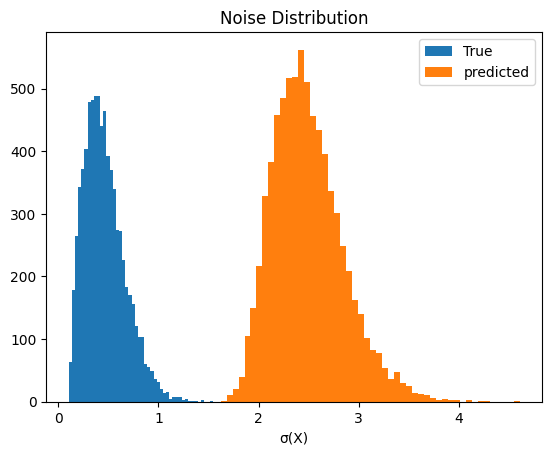

In [22]:
plt.hist(true_sigma_train, bins=50, label='True')
plt.hist(sigma_X_train, bins=50, label='predicted')
plt.legend()
plt.xlabel('σ(X)'), plt.title('Noise Distribution')
plt.show()

In [23]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

class TweedieCorrector:
    def __init__(self, bandwidth=0.1, epsilon=1e-5):
        self.bandwidth = bandwidth
        self.epsilon = epsilon
        
    def fit(self, Y_train, Ŷ_train, sigma_X_train):
        """Train the corrector using your existing data"""
        # Store training data for kernel regression
        self.Y_train = Y_train
        self.Ŷ_train = Ŷ_train
        self.w_train = 1 / (sigma_X_train**2 + self.epsilon)
        
        # Estimate marginal density of Y
        self.kde = gaussian_kde(Y_train)
        
        return self
    
    def correct(self, Y_obs, delta=1e-5):
        """Apply correction to new observations"""
        # Finite difference setup
        log_p_plus = self.kde.logpdf(Y_obs + delta)
        log_p_minus = self.kde.logpdf(Y_obs - delta)
        d_logp = (log_p_plus - log_p_minus) / (2 * delta)
        
        # Kernel weights
        weights = np.exp(-0.5*((self.Y_train - Y_obs)/self.bandwidth)**2)
        sum_weights = np.sum(weights) + self.epsilon
        
        # Compute conditional expectations
        E_w = np.sum(self.w_train * weights) / sum_weights
        E_wŶ = np.sum(self.w_train * self.Ŷ_train * weights) / sum_weights
        E_Ŷ = np.sum(self.Ŷ_train * weights) / sum_weights
        
        # Compute covariance term
        Cov_wŶ = E_wŶ - E_w * E_Ŷ
        
        # Apply correction formula
        Ŷ_corrected = Y_obs + (d_logp - Cov_wŶ) / E_w
        
        return Ŷ_corrected

'''# Example usage -------------------------------------------------
# Assuming you have:
# - Y_train: True labels (n_samples,)
# - Ŷ_train: Model predictions (n_samples,)
# - sigma_X_train: Uncertainty estimates (n_samples,)

# Initialize and train corrector
corrector = TweedieCorrector(bandwidth=0.2).fit(Y_train, Ŷ_new_train, sigma_X_train)

# Apply to training data (or new observations)
Ŷ_corrected_test = np.array([corrector.correct(y) for y in tqdm(Y_test)])

# Evaluate performance
print(f"Original MSE: {mean_squared_error(Y_test, Ŷ_test):.4f}")
print(f"Corrected MSE: {mean_squared_error(Y_test, Ŷ_corrected_test):.4f}")

# Visualize results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(Y_test, Ŷ_test, alpha=0.3)
plt.title("Original Predictions")
plt.xlabel("True Y"), plt.ylabel("Predicted Ŷ")

plt.subplot(122)
plt.scatter(Y_test, Ŷ_corrected_test, alpha=0.3, c='r')
plt.title("Tweedie-Corrected Predictions")
plt.xlabel("True Y"), plt.ylabel("Corrected Ŷ*")
plt.tight_layout()
plt.show()'''


'# Example usage -------------------------------------------------\n# Assuming you have:\n# - Y_train: True labels (n_samples,)\n# - Ŷ_train: Model predictions (n_samples,)\n# - sigma_X_train: Uncertainty estimates (n_samples,)\n\n# Initialize and train corrector\ncorrector = TweedieCorrector(bandwidth=0.2).fit(Y_train, Ŷ_new_train, sigma_X_train)\n\n# Apply to training data (or new observations)\nŶ_corrected_test = np.array([corrector.correct(y) for y in tqdm(Y_test)])\n\n# Evaluate performance\nprint(f"Original MSE: {mean_squared_error(Y_test, Ŷ_test):.4f}")\nprint(f"Corrected MSE: {mean_squared_error(Y_test, Ŷ_corrected_test):.4f}")\n\n# Visualize results\nplt.figure(figsize=(10, 5))\nplt.subplot(121)\nplt.scatter(Y_test, Ŷ_test, alpha=0.3)\nplt.title("Original Predictions")\nplt.xlabel("True Y"), plt.ylabel("Predicted Ŷ")\n\nplt.subplot(122)\nplt.scatter(Y_test, Ŷ_corrected_test, alpha=0.3, c=\'r\')\nplt.title("Tweedie-Corrected Predictions")\nplt.xlabel("True Y"), plt.ylabel("Corr

Original MSE: 8.4822
Corrected MSE: 0.0000


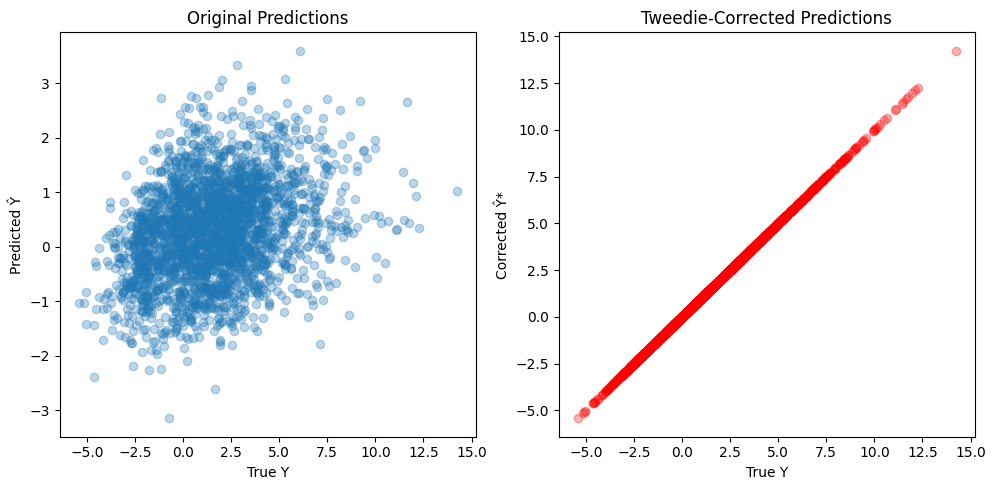

In [6]:
# Evaluate performance
print(f"Original MSE: {mean_squared_error(Y_test[Y_test < 15], Ŷ_test[Y_test < 15]):.4f}")
print(f"Corrected MSE: {mean_squared_error(Y_test[Y_test < 15], Ŷ_corrected_test[Y_test < 15]):.4f}")

# Visualize results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(Y_test[Y_test < 15], Ŷ_test[Y_test < 15], alpha=0.3)
plt.title("Original Predictions")
plt.xlabel("True Y"), plt.ylabel("Predicted Ŷ")

plt.subplot(122)
plt.scatter(Y_test[Y_test < 15], Ŷ_corrected_test[Y_test < 15], alpha=0.3, c='r')
plt.title("Tweedie-Corrected Predictions")
plt.xlabel("True Y"), plt.ylabel("Corrected Ŷ*")
plt.tight_layout()
plt.show()

In [24]:
from concurrent.futures import ProcessPoolExecutor

# Initialize and train corrector
corrector = TweedieCorrector(bandwidth=0.2).fit(Y_train, Ŷ_new_train.flatten().cpu().numpy(), sigma_X_train)

def correct_parallel(y):
    return corrector.correct(y)

# Apply to new observations
# Using ProcessPoolExecutor to parallelize the operation
with ProcessPoolExecutor() as executor:
    # Apply the corrector in parallel
    Ŷ_corrected_test = list(tqdm(executor.map(correct_parallel, Y_test), total=len(Y_test)))
    Ŷ_corrected_test = np.array(Ŷ_corrected_test)

100%|██████████| 2500/2500 [02:18<00:00, 18.09it/s]


Original MSE: 7.7684
Corrected MSE: 0.0000


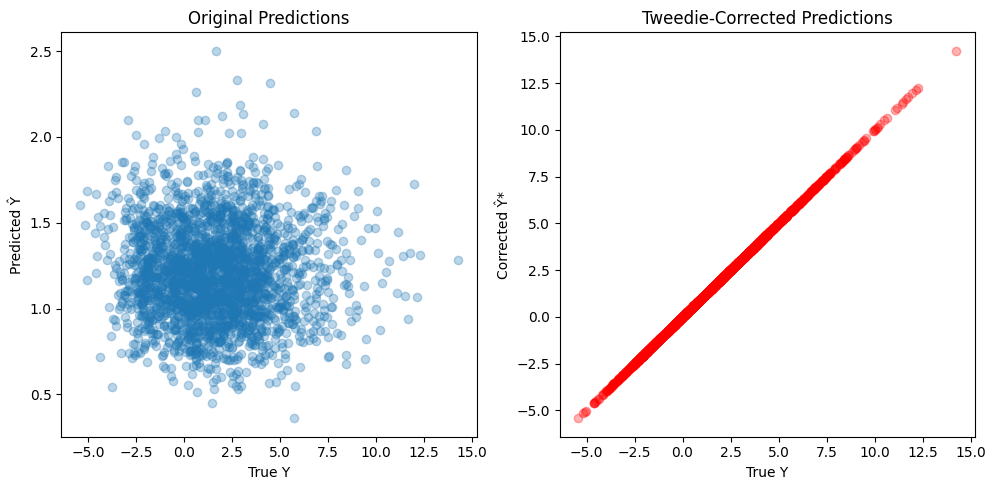

In [25]:
# Get predictions
with torch.no_grad():
    Ŷ_new_test, logvar = model(torch.tensor(X_test).cuda().float())
    sigma_X_test = np.sqrt(np.exp(logvar.cpu().numpy()))

Ŷ_new_test = Ŷ_new_test.cpu().numpy()

# Evaluate performance
print(f"Original MSE: {mean_squared_error(Y_test[Y_test < 15], Ŷ_new_test[Y_test < 15]):.4f}")
print(f"Corrected MSE: {mean_squared_error(Y_test[Y_test < 15], Ŷ_corrected_test[Y_test < 15]):.4f}")

# Visualize results
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(Y_test[Y_test < 15], Ŷ_new_test[Y_test < 15], alpha=0.3)
plt.title("Original Predictions")
plt.xlabel("True Y"), plt.ylabel("Predicted Ŷ")

plt.subplot(122)
plt.scatter(Y_test[Y_test < 15], Ŷ_corrected_test[Y_test < 15], alpha=0.3, c='r')
plt.title("Tweedie-Corrected Predictions")
plt.xlabel("True Y"), plt.ylabel("Corrected Ŷ*")
plt.tight_layout()
plt.show()

In [26]:
i = 0

print(Ŷ_new_test.flatten()[i], sigma_X_test.flatten()[i], Y_test[i])
print(Ŷ_new_test.flatten()[i+1], sigma_X_test.flatten()[i+1], Y_test[i+1])
print(Ŷ_new_test.flatten()[i+2], sigma_X_test.flatten()[i+2], Y_test[i+2])

1.1643959 2.3504267 -1.5500623377263714
1.0440023 2.162704 2.1327821882522247
1.1201584 2.257266 4.788749782123778
